In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from math import log

C:\Users\Rostom\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
main_folder = "C:/Users/Rostom/Videos/5SDBD/Projet_Intégrateur/archive/"
ATTR_PATH = main_folder + "list_attr_celeba.csv"  
PARTITION_PATH = main_folder + "list_eval_partition.csv" 
IMAGES_PATH = main_folder + "img_align_celeba/img_align_celeba/"  
MODEL_HANDLE = "./model" 
IMAGE_SIZE = (220, 220)

#Performance
BATCH_SIZE = 128
#BATCH_SIZE = 100
TRAIN_SAMPLE = 20000
VALIDATION_SAMPLE = 4000
NUM_EPOCHS = 3
#NUM_EPOCHS = 50

In [3]:
def select_best_features():
    df1 = pd.read_csv(ATTR_PATH, delimiter=',')
    df1.dataframeName = 'list_attr_celeba.csv'
    scores=[]
    for column in df1:
        if column != 'image_id':
            a = len(df1[df1[column] == 1])
            b = len(df1[df1[column] == -1])
            score = abs(a-b)/(a+b)
            scores.append((column,1/score))
    scores.sort(reverse = True)
    scores.sort(key=lambda a: a[1])
    scores.reverse()
    N=22
    scores_subset = [x for index, x in enumerate(scores) if index < N]
    selected_features = [scores_subset[i][0] for i in range(len(scores_subset))]
    
    #Manual tweaking
    selected_features.remove('Attractive')
    return selected_features

select_best_features()

['Mouth_Slightly_Open',
 'Smiling',
 'Wearing_Lipstick',
 'High_Cheekbones',
 'Male',
 'Heavy_Makeup',
 'Wavy_Hair',
 'Oval_Face',
 'Pointy_Nose',
 'Arched_Eyebrows',
 'Big_Lips',
 'Black_Hair',
 'Big_Nose',
 'Young',
 'Straight_Hair',
 'Brown_Hair',
 'Bags_Under_Eyes',
 'Wearing_Earrings',
 'No_Beard',
 'Bangs',
 'Blond_Hair']

In [4]:
df = pd.merge(pd.read_csv(PARTITION_PATH), pd.read_csv(ATTR_PATH), on="image_id")
df.head()
for column in df:
    print(column)
features_str = select_best_features()  

image_id
partition
5_o_Clock_Shadow
Arched_Eyebrows
Attractive
Bags_Under_Eyes
Bald
Bangs
Big_Lips
Big_Nose
Black_Hair
Blond_Hair
Blurry
Brown_Hair
Bushy_Eyebrows
Chubby
Double_Chin
Eyeglasses
Goatee
Gray_Hair
Heavy_Makeup
High_Cheekbones
Male
Mouth_Slightly_Open
Mustache
Narrow_Eyes
No_Beard
Oval_Face
Pale_Skin
Pointy_Nose
Receding_Hairline
Rosy_Cheeks
Sideburns
Smiling
Straight_Hair
Wavy_Hair
Wearing_Earrings
Wearing_Hat
Wearing_Lipstick
Wearing_Necklace
Wearing_Necktie
Young


In [5]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

def load_and_preprocess_from_path_label(path, 
    Mouth_Slightly_Open, Smiling, Wearing_Lipstick, High_Cheekbones, Male, Heavy_Makeup, Wavy_Hair, Oval_Face, Pointy_Nose, Arched_Eyebrows, Big_Lips, Black_Hair, Big_Nose, Young, Straight_Hair, Brown_Hair, Bags_Under_Eyes, Wearing_Earrings, No_Beard, Bangs, Blond_Hair):
    images = load_and_preprocess_image(path)
    return images, Mouth_Slightly_Open, Smiling, Wearing_Lipstick, High_Cheekbones, Male, Heavy_Makeup, Wavy_Hair, Oval_Face, Pointy_Nose,Arched_Eyebrows, Big_Lips, Black_Hair, Big_Nose, Young, Straight_Hair, Brown_Hair, Bags_Under_Eyes, Wearing_Earrings, No_Beard, Bangs, Blond_Hair

def init_dataset(df,features_str):
    a = ([IMAGES_PATH + image_id for image_id in df["image_id"]],)
    for feature in features_str:
        b =  list(df[feature].replace(-1,0))
        a = a + (b,)
    return a


def build_dataset_from_df(df):
    ds = tf.data.Dataset.from_tensor_slices(init_dataset(df,features_str))
    ds = ds.map(load_and_preprocess_from_path_label)
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

In [6]:
train_df = df.loc[df["partition"] == 0].head(TRAIN_SAMPLE)
train_ds = build_dataset_from_df(train_df)

val_df = df.loc[df["partition"] == 1].head(VALIDATION_SAMPLE)
val_ds = build_dataset_from_df(val_df)

#val_df

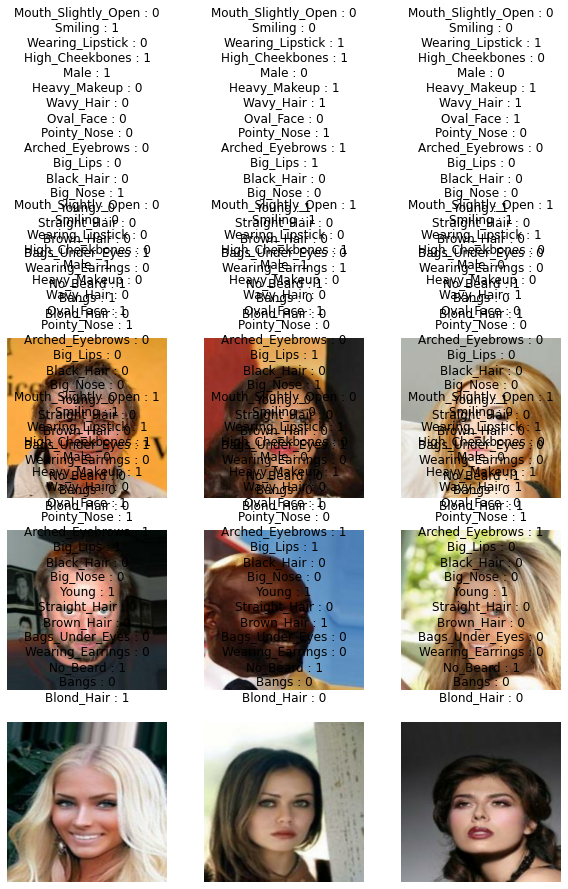

In [7]:
image, Mouth_Slightly_Open, Smiling, Wearing_Lipstick, High_Cheekbones, Male, Heavy_Makeup, Wavy_Hair, Oval_Face, Pointy_Nose, Arched_Eyebrows, Big_Lips, Black_Hair, Big_Nose, Young, Straight_Hair, Brown_Hair, Bags_Under_Eyes, Wearing_Earrings, No_Beard, Bangs, Blond_Hair = next(iter(train_ds))
features = [ Mouth_Slightly_Open, Smiling, Wearing_Lipstick, High_Cheekbones, Male, Heavy_Makeup, Wavy_Hair, Oval_Face, Pointy_Nose, Arched_Eyebrows, Big_Lips, Black_Hair, Big_Nose, Young, Straight_Hair, Brown_Hair, Bags_Under_Eyes, Wearing_Earrings, No_Beard, Bangs, Blond_Hair]
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i].numpy().astype("uint8"))
    s = ""
    for j in range(len(features)):
        s+= str(features_str[j]) +" : "
        s+= str(features[j][i].numpy())
        s+= '\n'
    plt.title(s)
    plt.axis("off")

In [8]:
normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = False
if do_data_augmentation:
    preprocessing_model.add(tf.keras.layers.RandomRotation(0.2))
    preprocessing_model.add(tf.keras.layers.RandomTranslation(0, 0.2))
    preprocessing_model.add(tf.keras.layers.RandomTranslation(0.2, 0))
    preprocessing_model.add(tf.keras.layers.RandomZoom(0.2, 0.2))
    preprocessing_model.add(tf.keras.layers.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images,  Mouth_Slightly_Open, Smiling, Wearing_Lipstick, High_Cheekbones, Male, Heavy_Makeup, Wavy_Hair, Oval_Face, Pointy_Nose, Arched_Eyebrows, Big_Lips, Black_Hair, Big_Nose, Young, Straight_Hair, Brown_Hair, Bags_Under_Eyes, Wearing_Earrings, No_Beard, Bangs, Blond_Hair:
                        (preprocessing_model(images), ( Mouth_Slightly_Open, Smiling, Wearing_Lipstick, High_Cheekbones, Male, Heavy_Makeup, Wavy_Hair, Oval_Face, Pointy_Nose, Arched_Eyebrows, Big_Lips, Black_Hair, Big_Nose, Young, Straight_Hair, Brown_Hair, Bags_Under_Eyes, Wearing_Earrings, No_Beard, Bangs, Blond_Hair)))

val_ds = val_ds.map(lambda images,  Mouth_Slightly_Open, Smiling, Wearing_Lipstick, High_Cheekbones, Male, Heavy_Makeup, Wavy_Hair, Oval_Face, Pointy_Nose, Arched_Eyebrows, Big_Lips, Black_Hair, Big_Nose, Young, Straight_Hair, Brown_Hair, Bags_Under_Eyes, Wearing_Earrings, No_Beard, Bangs, Blond_Hair:
                    (normalization_layer(images), ( Mouth_Slightly_Open, Smiling, Wearing_Lipstick, High_Cheekbones, Male, Heavy_Makeup, Wavy_Hair, Oval_Face, Pointy_Nose, Arched_Eyebrows, Big_Lips, Black_Hair, Big_Nose, Young, Straight_Hair, Brown_Hair, Bags_Under_Eyes, Wearing_Earrings, No_Beard, Bangs, Blond_Hair)))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [9]:
do_fine_tuning = False
input = tf.keras.Input(shape=IMAGE_SIZE + (3,))
x = hub.KerasLayer(MODEL_HANDLE, trainable=do_fine_tuning)(input)
x = tf.keras.layers.Dropout(rate=0.2)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)

outs = []

for feature in features_str:
    out = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation="sigmoid", name=feature)(x)
    outs.append(out)


model = tf.keras.Model( inputs = input, outputs = outs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 220, 220, 3  0           []                               
                                )]                                                                
                                                                                                  
 keras_layer (KerasLayer)       (None, 1280)         5919312     ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 1280)         0           ['keras_layer[0][0]']            
                                                                                                  
 dense (Dense)                  (None, 128)          163968      ['dropout[0][0]']            

In [10]:
model.compile(
    loss = {           
        "Mouth_Slightly_Open": tf.keras.losses.BinaryCrossentropy(),
        "Smiling": tf.keras.losses.BinaryCrossentropy(),
        "Wearing_Lipstick": tf.keras.losses.BinaryCrossentropy(),
        "High_Cheekbones": tf.keras.losses.BinaryCrossentropy(),
        "Male": tf.keras.losses.BinaryCrossentropy(),
        "Heavy_Makeup": tf.keras.losses.BinaryCrossentropy(),
        "Wavy_Hair": tf.keras.losses.BinaryCrossentropy(),
        "Oval_Face": tf.keras.losses.BinaryCrossentropy(),
        "Pointy_Nose": tf.keras.losses.BinaryCrossentropy(),
        "Arched_Eyebrows": tf.keras.losses.BinaryCrossentropy(),
        "Big_Lips": tf.keras.losses.BinaryCrossentropy(),
        "Black_Hair": tf.keras.losses.BinaryCrossentropy(),
        "Big_Nose": tf.keras.losses.BinaryCrossentropy(),
        "Young": tf.keras.losses.BinaryCrossentropy(),
        "Straight_Hair": tf.keras.losses.BinaryCrossentropy(),
        "Brown_Hair": tf.keras.losses.BinaryCrossentropy(),
        "Bags_Under_Eyes": tf.keras.losses.BinaryCrossentropy(),
        "Wearing_Earrings": tf.keras.losses.BinaryCrossentropy(),
        "No_Beard": tf.keras.losses.BinaryCrossentropy(),
        "Bangs": tf.keras.losses.BinaryCrossentropy(),
        "Blond_Hair": tf.keras.losses.BinaryCrossentropy()
    },
    metrics = {
        "Mouth_Slightly_Open": 'accuracy',
        "Smiling": 'accuracy',
        "Wearing_Lipstick": 'accuracy',
        "High_Cheekbones": 'accuracy',
        "Male": 'accuracy',
        "Heavy_Makeup": 'accuracy',
        "Wavy_Hair": 'accuracy',
        "Oval_Face": 'accuracy',
        "Pointy_Nose": 'accuracy',
        "Arched_Eyebrows": 'accuracy',
        "Big_Lips": 'accuracy',
        "Black_Hair": 'accuracy',
        "Big_Nose": 'accuracy',
        "Young": 'accuracy',
        "Straight_Hair": 'accuracy',
        "Brown_Hair": 'accuracy',
        "Bags_Under_Eyes": 'accuracy',
        "Wearing_Earrings": 'accuracy',
        "No_Beard": 'accuracy',
        "Bangs": 'accuracy',
        "Blond_Hair": 'accuracy'
    },
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
)

In [11]:
steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(val_df) // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=NUM_EPOCHS, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/3
156/156 [==============================] - 567s 4s/step - loss: 9.0283 - Mouth_Slightly_Open_loss: 0.6183 - Smiling_loss: 0.5358 - Wearing_Lipstick_loss: 0.2758 - High_Cheekbones_loss: 0.5477 - Male_loss: 0.2054 - Heavy_Makeup_loss: 0.3374 - Wavy_Hair_loss: 0.4592 - Oval_Face_loss: 0.5850 - Pointy_Nose_loss: 0.5613 - Arched_Eyebrows_loss: 0.4674 - Big_Lips_loss: 0.5373 - Black_Hair_loss: 0.3977 - Big_Nose_loss: 0.4654 - Young_loss: 0.3958 - Straight_Hair_loss: 0.4847 - Brown_Hair_loss: 0.4438 - Bags_Under_Eyes_loss: 0.4652 - Wearing_Earrings_loss: 0.3921 - No_Beard_loss: 0.2991 - Bangs_loss: 0.3075 - Blond_Hair_loss: 0.2424 - Mouth_Slightly_Open_accuracy: 0.6524 - Smiling_accuracy: 0.7278 - Wearing_Lipstick_accuracy: 0.8854 - High_Cheekbones_accuracy: 0.7242 - Male_accuracy: 0.9161 - Heavy_Makeup_accuracy: 0.8405 - Wavy_Hair_accuracy: 0.7777 - Oval_Face_accuracy: 0.7070 - Pointy_Nose_accuracy: 0.7157 - Arched_Eyebrows_accuracy: 0.7585 - Big_Lips_accuracy: 0.7497 - Black_Hair_

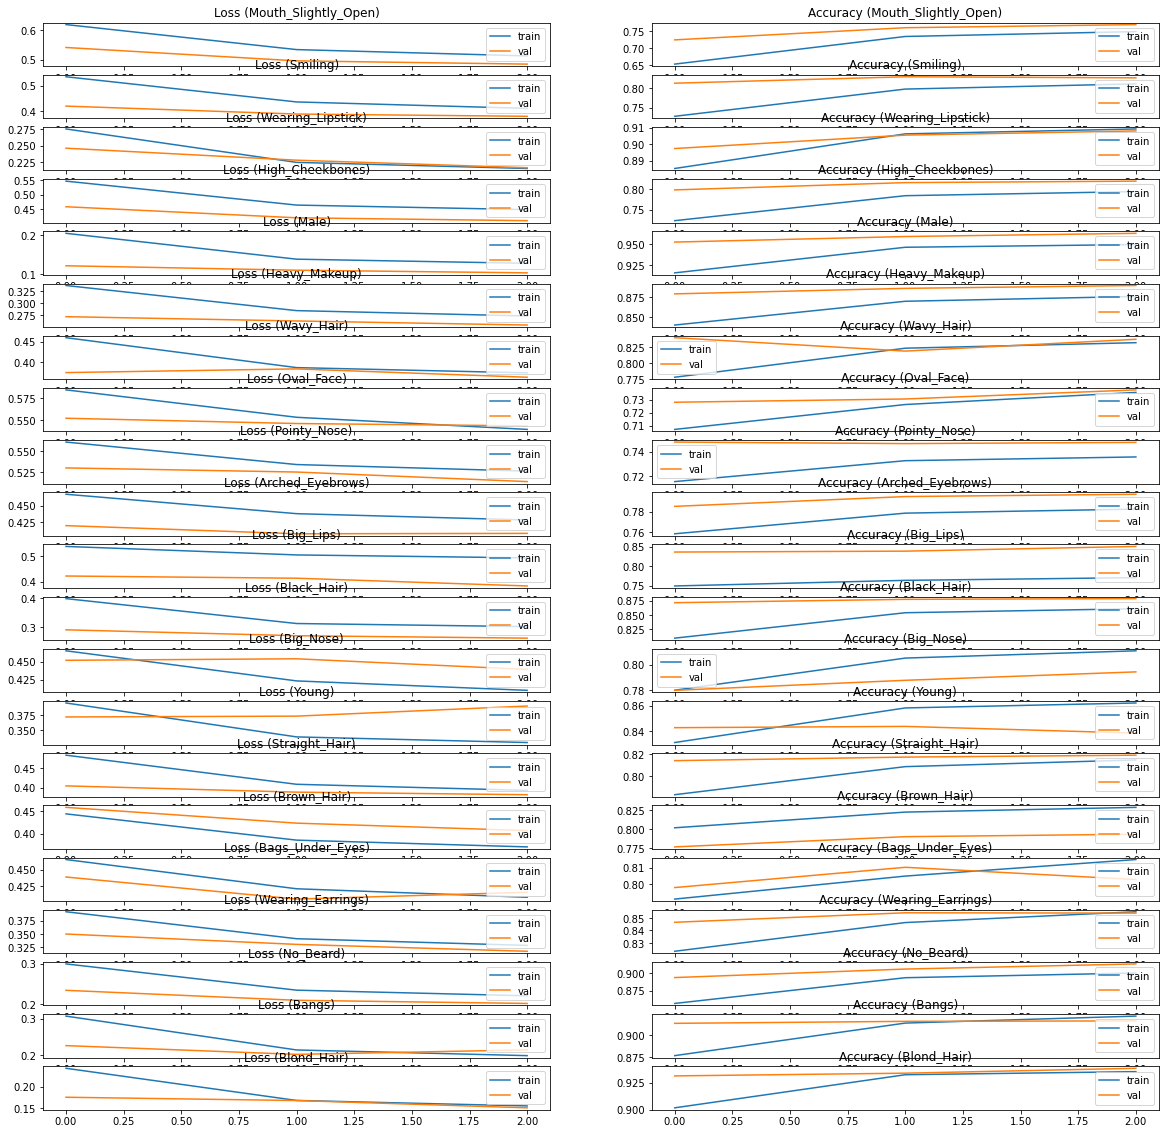

In [12]:
fig, ax = plt.subplots(len(features_str), 2, figsize=(20, 20))
for i, c in enumerate(features_str):
    ax[i, 0].plot(hist[f"{c}_loss"], label="train")
    ax[i, 0].plot(hist[f"val_{c}_loss"], label="val")
    ax[i, 0].set_title(f"Loss ({c})")
    ax[i, 0].legend()
    ax[i, 1].plot(hist[f"{c}_accuracy"], label="train")
    ax[i, 1].plot(hist[f"val_{c}_accuracy"], label="val")
    ax[i, 1].set_title(f"Accuracy ({c})")
    ax[i, 1].legend()
plt.show()

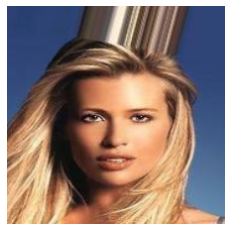

1/1 [==============================] - 4s 4s/step
Mouth_Slightly_Open: actual 0, predicted 0 (0.3090)
Smiling: actual 0, predicted 0 (0.0439)
Wearing_Lipstick: actual 1, predicted 1 (0.8126)
High_Cheekbones: actual 0, predicted 0 (0.1064)
Male: actual 0, predicted 0 (0.0191)
Heavy_Makeup: actual 1, predicted 1 (0.5477)
Wavy_Hair: actual 0, predicted 0 (0.4195)
Oval_Face: actual 0, predicted 0 (0.0890)
Pointy_Nose: actual 0, predicted 1 (0.5899)
Arched_Eyebrows: actual 0, predicted 0 (0.3122)
Big_Lips: actual 0, predicted 0 (0.3100)
Black_Hair: actual 0, predicted 0 (0.0008)
Big_Nose: actual 0, predicted 0 (0.0121)
Young: actual 1, predicted 1 (0.9975)
Straight_Hair: actual 0, predicted 0 (0.4345)
Brown_Hair: actual 0, predicted 0 (0.0730)
Bags_Under_Eyes: actual 0, predicted 0 (0.0273)
Wearing_Earrings: actual 0, predicted 0 (0.0591)
No_Beard: actual 1, predicted 1 (0.9649)
Bangs: actual 0, predicted 0 (0.1341)
Blond_Hair: actual 0, predicted 1 (0.9059)


In [13]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
plt.imshow(image)
plt.axis('off')
plt.show()
#print(x)

prediction_scores = model.predict(np.expand_dims(image, axis=0))
for i, label in enumerate(features_str):
    pred = prediction_scores[i][0][0]
    print(f"{label}: actual {y[i][0]}, predicted {1 if pred > 0.5 else 0} ({format(pred, '.4f')})")

In [14]:
def open_images(inference_folder: str) -> np.ndarray:
    images = []
    for img in os.listdir(inference_folder):
        img_location = os.path.join(inference_folder, img)  
        with Image.open(img_location) as img:  
            img = np.array(img)
            img = img[:, :, :3]
            img = np.expand_dims(img, axis=0)  
        images.append(img)
    images_array = np.vstack(images) 
    return images_array

In [15]:
from PIL import Image
import os, sys

path = "./image_samples/"
dirs = os.listdir( path )
resized_path = "./images_resized/"

def resize():
    for item in dirs:
        print(item)
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            im = im.convert('RGB')
            f, e = os.path.splitext(path+item)
            imResize = im.resize((220,220), Image.ANTIALIAS)
            imResize.save(resized_path + item + '_resized.jpg', 'JPEG', quality=90)

resize()

162771.jpg
321116120_613149164144508_8497526687511687835_n.jpg
321240135_698995238546479_983226794941031556_n.jpg
321524186_733681281318622_8413083612589801687_n.jpg
321553608_529503195799433_8824502125631363198_n.jpg
321583445_1566567133787809_2598837799567296422_n.jpg
321717131_5845034862248080_5614988834469057400_n.jpg
321978282_2789787894485100_6684771661562603172_n.jpg
321979583_1268521123877266_170285861591344890_n.jpg
322307120_664010718751666_8540839711723716088_n.jpg
322595586_709744033848953_3270901739627174524_n.jpg
celia.jpg
jean.jpg
nada.jpg
rostom.jpg
salma.jpg
souhail.jpg
wissem.jpg
yasser.jpg


In [16]:
def display_image(image,s):
    plt.imshow(image)
    plt.title(s)
    plt.figure()

In [17]:
def image_prediction(prediction_score):
    s = ""
    for i, label in enumerate(features_str):
        pred = prediction_score[i][0][0]
        s += f"{label}: predicted {1 if pred > 0.5 else 0} ({format(pred, '.4f')})"
        s +="\n"
    return s  

1/1 [==============================] - 0s 48ms/step


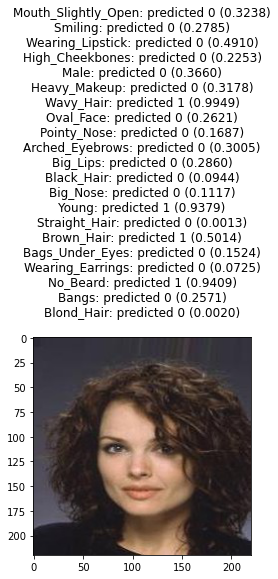

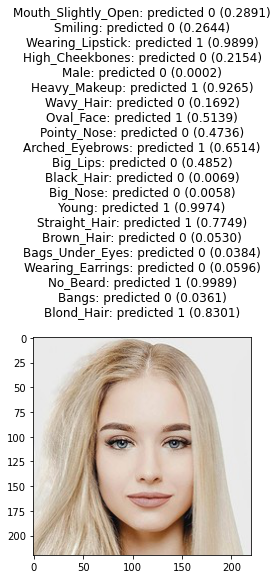

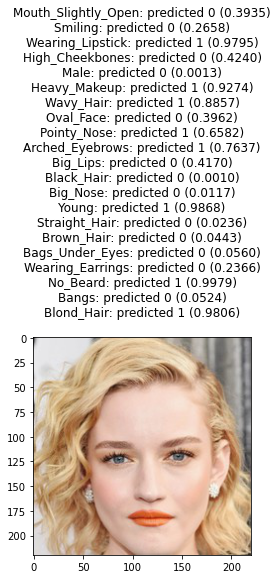

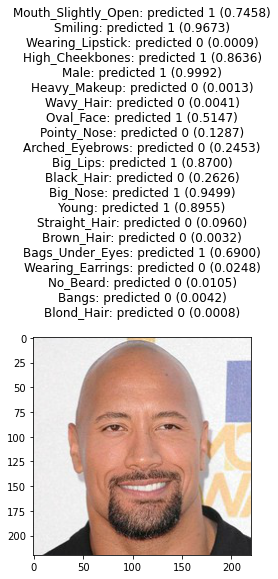

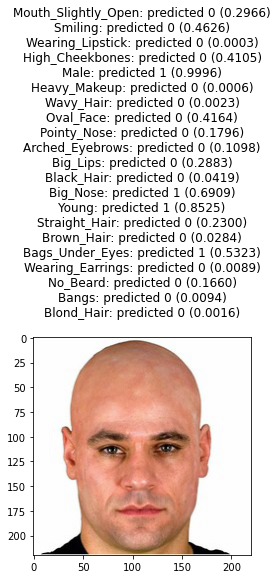

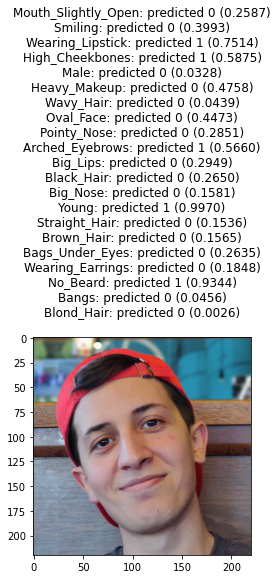

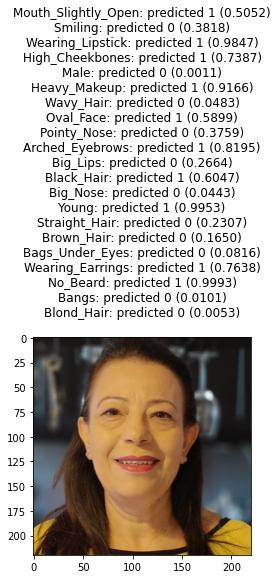

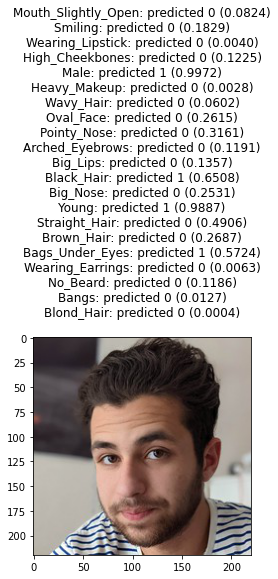

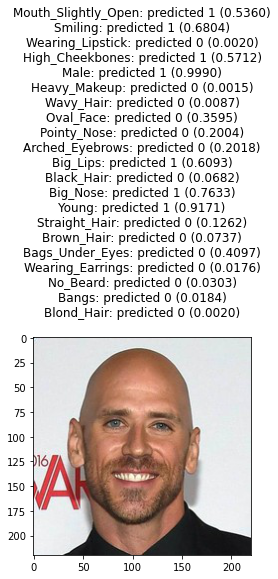

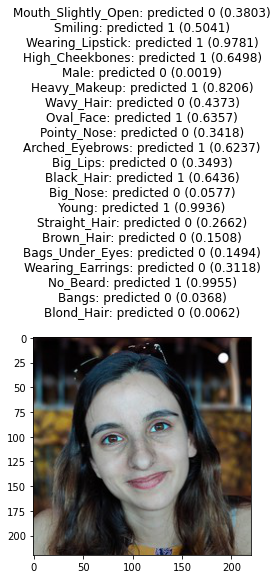

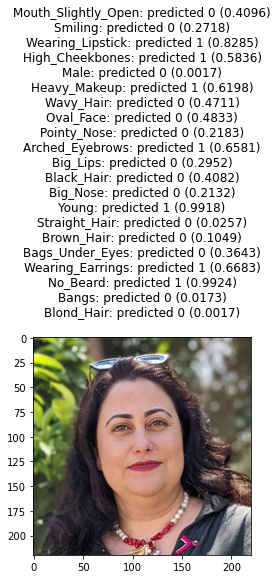

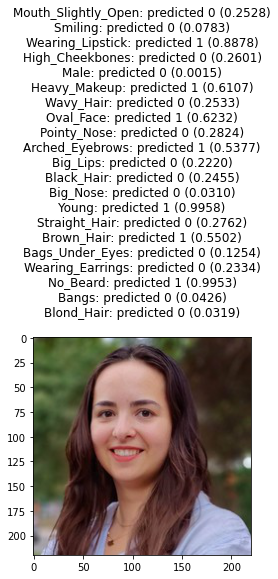

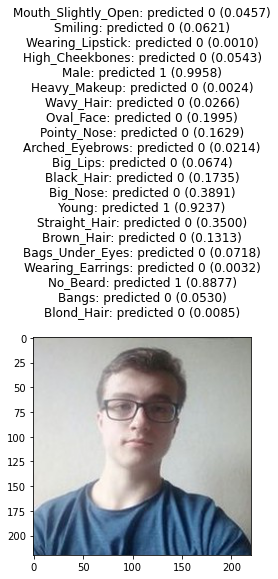

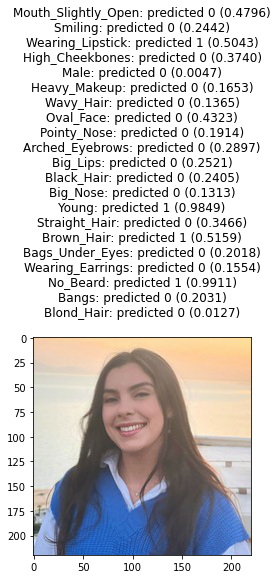

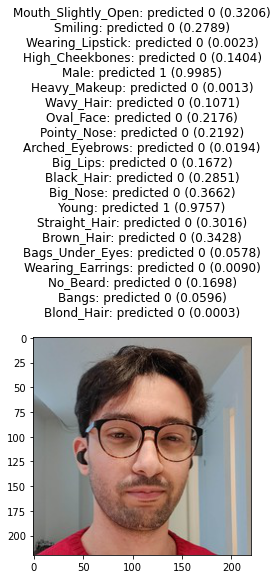

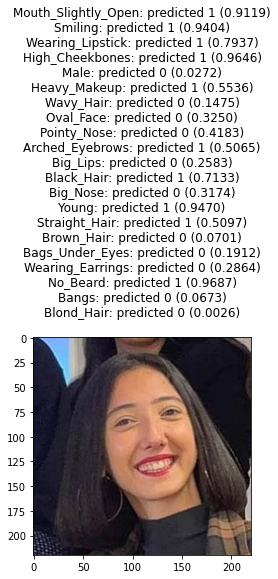

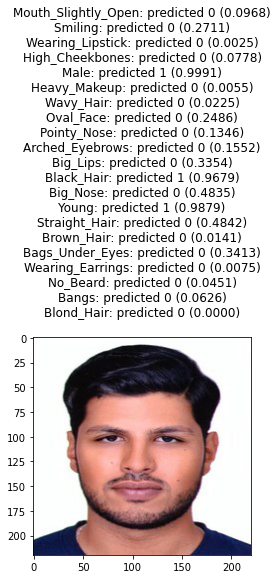

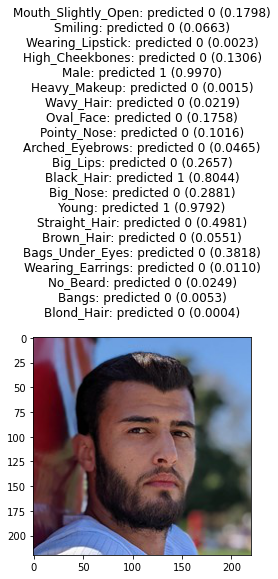

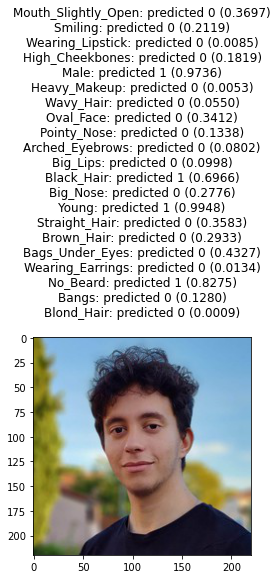

<Figure size 432x288 with 0 Axes>

In [18]:
import os
from PIL import Image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
images = open_images(resized_path)
c=0
for image in images:
    #img_batch = np.expand_dims(image * 10e-4, axis=0)
    img_batch = np.expand_dims(image, axis=0)
    #print(img_batch)
    normalizedData = (img_batch-np.min(img_batch))/(np.max(img_batch)-np.min(img_batch))
    #print(normalizedData)
    prediction_score= model.predict(normalizedData)
    s = image_prediction(prediction_score)
    display_image(image,s)